In [1]:
import whisper
from pytube import YouTube

c:\Users\Johan\Documents\Projects\Python\SenadoWhisper\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
vModel = whisper.load_model("base")
vLink = "https://www.youtube.com/watch?v=tkY3tR9_ryI"
vYoutubeObject = YouTube(vLink)

In [3]:
cAUDIO_FILE = "tmp.mp4"
vAudioStreams = vYoutubeObject.streams.filter(only_audio = True)
print("Audio stream:", vAudioStreams[1])
vAudioStreams[1].download(filename = cAUDIO_FILE)

Audio stream: <Stream: itag="249" mime_type="audio/webm" abr="50kbps" acodec="opus" progressive="False" type="audio">


'c:\\Users\\Johan\\Documents\\Projects\\Python\\SenadoWhisper\\notebooks\\tmp.mp4'

In [4]:
vResult = vModel.transcribe(cAUDIO_FILE)

c:\Users\Johan\Documents\Projects\Python\SenadoWhisper\env\lib\site-packages\whisper\transcribe.py:114: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


In [5]:
import json

with open("transcribe.json", "w") as vFile:
    vFile.write(json.dumps(vResult))

In [14]:
from transformers import pipeline

gClassifier = pipeline(
    "zero-shot-classification", 
    model = "Recognai/bert-base-spanish-wwm-cased-xnli"
)

In [15]:
vResult["segments"][0]["text"]

' ¿Qué buena idea no funciona porque la gente es basura?'

In [42]:
gCandidateLabels = ["Feliz", "Frustado", "Neutral", "Satisfecho"]

vClassifierResult = gClassifier(
    vResult["segments"][0]["text"],
    candidate_labels = gCandidateLabels,
    hypothesis_template = "El texto se puede clasificar su mensaje emocional como: {}"
)
vZipResult = [x for x in zip(vClassifierResult["labels"], vClassifierResult["scores"])]
vZipResult

[('Neutral', 0.3934624195098877),
 ('Satisfecho', 0.3514392375946045),
 ('Frustado', 0.17141038179397583),
 ('Feliz', 0.08368799090385437)]

In [48]:
vProcessedText = list()
for tSegment in vResult["segments"]:
    vClassifierResult = gClassifier(
        tSegment["text"],
        candidate_labels = gCandidateLabels,
        hypothesis_template = "The spanish text it's into the next emotion: {}"
    )
    vZipResult = [x for x in zip(vClassifierResult["labels"], vClassifierResult["scores"])]
    vMaxScore = vZipResult[0][1]
    vMaxTag = vZipResult[0][0]

    for tTag, tScore in vZipResult:
        if vMaxScore < tScore:
            vMaxScore = tScore
            vMaxTag = tTag

    vProcessedText.append({
        "id": tSegment["id"],
        "text": tSegment["text"],
        "start": tSegment["start"],
        "end": tSegment["end"],
        "score": vMaxScore,
        "tag": vMaxTag
    })

In [59]:
import matplotlib.pyplot as plt
import numpy as np

vFrustadoList = list()
vFelizList = list()
vNeutralList = list()
vSatisfechoList = list()
vIndex = list()

for tSegment in vProcessedText[0:30]:
    vIndex.append(tSegment["start"])
    if tSegment["tag"] == "Frustado":
        vFrustadoList.append(1)
        vFelizList.append(0)
        vNeutralList.append(0)
        vSatisfechoList.append(0)
    if tSegment["tag"] == "Feliz":
        vFelizList.append(1)
        vFrustadoList.append(0)
        vNeutralList.append(0)
        vSatisfechoList.append(0)
    if tSegment["tag"] == "Neutral":
        vNeutralList.append(1)
        vFrustadoList.append(0)
        vFelizList.append(0)
        vSatisfechoList.append(0)
    if tSegment["tag"] == "Satisfecho":
        vSatisfechoList.append(1)
        vFrustadoList.append(0)
        vFelizList.append(0)
        vNeutralList.append(0)

vFrustadoCounter = 0
vFelizCounter = 0
vNeutralCounter = 0
vSatisfechoCounter = 0

for i, _ in enumerate(vFrustadoList):
    vFrustadoCounter = vFrustadoCounter + vFrustadoList[i]
    vFelizCounter = vFelizCounter + vFelizList[i]
    vNeutralCounter = vNeutralCounter + vNeutralList[i]
    vSatisfechoCounter = vSatisfechoCounter + vSatisfechoList[i]

    vFrustadoList[i] = vFrustadoCounter
    vFelizList[i] = vFelizCounter
    vNeutralList[i] = vNeutralCounter
    vSatisfechoList[i] = vSatisfechoCounter

vFrustadoList = np.array(vFrustadoList)
vFelizList = np.array(vFelizList)
vNeutralList = np.array(vNeutralList)
vSatisfechoList = np.array(vSatisfechoList)
vIndex = np.array(vIndex)

#vProcessedText
vSatisfechoList

array([ 0,  0,  0,  0,  0,  0,  1,  2,  3,  3,  4,  4,  5,  6,  7,  8,  8,
        9, 10, 10, 10, 11, 11, 12, 12, 12, 13, 14, 14, 14])

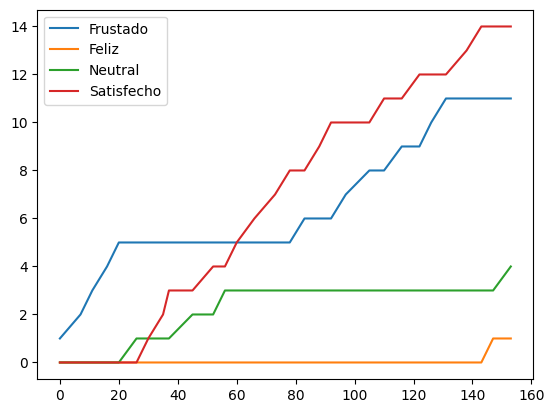

In [61]:
plt.plot(vIndex, vFrustadoList, label = "Frustado")
plt.plot(vIndex, vFelizList, label = "Feliz")
plt.plot(vIndex, vNeutralList, label = "Neutral")
plt.plot(vIndex, vSatisfechoList, label = "Satisfecho")
plt.legend()
plt.show()